In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lightgbm as lgb
from sklearn.linear_model import Ridge
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

## Data Loading and Processing

In [2]:
data_location = "data"

In [3]:
sales_data_train = pd.read_csv(f"{data_location}/train.csv", parse_dates=['date'], converters={'unit_sales': lambda s: np.log1p(float(s)) if float(s) > 0 else 0})
items_data = pd.read_csv(f"{data_location}/items.csv")
stores_data = pd.read_csv(f"{data_location}/stores.csv")
transactions_data = pd.read_csv(f"{data_location}/transactions.csv", parse_dates=['date'])
oil_data = pd.read_csv(f"{data_location}/oil.csv", parse_dates=['date'])
holidays_events_data = pd.read_csv(f"{data_location}/holidays_events.csv", parse_dates=['date'])

C:\Users\CSamarajeewa\AppData\Local\Temp\ipykernel_16852\1666722995.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data_train = pd.read_csv(f"{data_location}/train.csv", parse_dates=['date'], converters={'unit_sales': lambda s: np.log1p(float(s)) if float(s) > 0 else 0})


In [5]:
holidays_events_data['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [32]:
len(stores_data['city'].unique())

22

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
items_data['family_encoded'] = label_encoder.fit_transform(items_data['family'])

stores_data['type_encoded'] = label_encoder.fit_transform(stores_data['type'])
stores_data['city_encoded'] = label_encoder.fit_transform(stores_data['city'])
stores_data['state_encoded'] = label_encoder.fit_transform(stores_data['state'])

In [5]:
sales_data_train_formatted = sales_data_train.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
sales_data_train_formatted.columns = sales_data_train_formatted.columns.get_level_values(1)

In [8]:
sales_data_train_formatted.head()

date                2013-01-01  2013-01-02  2013-01-03  2013-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    0.000000    0.000000   
          103520           0.0    0.000000    0.000000    1.098612   
          103665           0.0    1.098612    1.386294    1.098612   
          105574           0.0    2.197225    1.609438    2.197225   

date                2013-01-05  2013-01-06  2013-01-07  2013-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000     0.00000   
          99197       0.000000    0.000000    0.000000     0.00000   
          103520      1.386294    0.000000    1.098612     1.94591   
          103665      1.609438    1.098612    0.693147     0.00000   
          105574      1.609438    1.098612    1.945910     1.94591   

date                2013-01-09  2013-01-10  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         96995       0.000000    0.693147  ...    1.098612    1.098612   
          99197       0.000000    0.000000  ...    0.000000    1.098612   
          103520      1.386294    0.693147  ...    0.000000    0.000000   
          103665      0.693147    1.945910  ...    0.693147    1.098612   
          105574      2.302585    1.609438  ...    0.000000    1.791759   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.693147    0.000000   
          99197       0.000000    1.098612    0.000000    0.000000   
          103520      1.386294    0.000000    1.386294    0.693147   
          103665      0.000000    2.079442    2.302585    1.098612   
          105574      2.079442    1.945910    2.397895    1.791759   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         96995       0.000000    0.000000    0.000000    0.000000  
          99197       0.000000    0.000000    0.000000    0.000000  
          103520      0.693147    0.693147    0.000000    0.000000  
          103665      0.000000    0.000000    0.693147    0.693147  
          105574      1.791759    0.000000    1.386294    1.609438  

[5 rows x 1684 columns]

In [6]:
stores_data_indexed = stores_data.set_index('store_nbr')
stores_data_indexed = stores_data_indexed.reindex(sales_data_train_formatted.index.get_level_values(0))
stores_data_indexed.head()

,city,state,type,cluster,type_encoded,city_encoded,state_encoded
store_nbr,,,,,,,
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12


In [7]:
items_data_indexed = items_data.set_index('item_nbr')
items_data_indexed = items_data_indexed.reindex(sales_data_train_formatted.index.get_level_values(1))
items_data_indexed.head()

,family,class,perishable,family_encoded
item_nbr,,,,
96995,GROCERY I,1093,0,12
99197,GROCERY I,1067,0,12
103520,GROCERY I,1028,0,12
103665,BREAD/BAKERY,2712,1,5
105574,GROCERY I,1045,0,12


## Preparing Dataset

In [11]:
def get_baseline_dataset(start_date, num_days=14, train=True):
  y = None
  X = pd.DataFrame({
      "family": items_data_indexed["family_encoded"].values,
      "class": items_data_indexed["class"].values,
      "perishable": items_data_indexed["perishable"].values,
      "store_type": stores_data_indexed["type_encoded"].values,
      "store_city": stores_data_indexed["city_encoded"].values,
      "store_cluster": stores_data_indexed["cluster"].values,
      "store_state": stores_data_indexed["state_encoded"].values,
  })

  if train:
    y = sales_data_train_formatted[pd.date_range(start_date, periods=num_days)].values

  return X, y

In [8]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]


def get_extended_dataset(start_date, num_days=14, train=True):
    y = None
    X = pd.DataFrame({
        "family": items_data_indexed["family_encoded"].values,
        "class": items_data_indexed["class"].values,
        "perishable": items_data_indexed["perishable"].values,
        "store_type": stores_data_indexed["type_encoded"].values,
        "store_city": stores_data_indexed["city_encoded"].values,
        "store_cluster": stores_data_indexed["cluster"].values,
        "store_state": stores_data_indexed["state_encoded"].values,
        "day_1": get_timespan(sales_data_train_formatted, start_date, 1, 1).values.ravel(),  # sales for day 1
        "mean_3": get_timespan(sales_data_train_formatted, start_date, 3, 3).mean(axis=1).values,  # mean sales over 3 days
        "mean_7": get_timespan(sales_data_train_formatted, start_date, 7, 7).mean(axis=1).values,  # mean sales over 7 days
        "mean_14": get_timespan(sales_data_train_formatted, start_date, 14, 14).mean(axis=1).values,  # mean sales over 14 days
        # "mean_30": get_timespan(sales_data_train_formatted, start_date, 30, 30).mean(axis=1).values,  # mean sales over 30 days
        # "mean_60": get_timespan(sales_data_train_formatted, start_date, 60, 60).mean(axis=1).values,  # mean sales over 60 days
        # "mean_140": get_timespan(sales_data_train_formatted, start_date, 140, 140).mean(axis=1).values,  # mean sales over 140 days
    })

    for i in range(7):
        X['mean_4_dow{}_sales'.format(i)] = get_timespan(sales_data_train_formatted, start_date, 28-i, 4, freq='7D').mean(axis=1).values
        # X['mean_20_dow{}_sales'.format(i)] = get_timespan(sales_data_train_formatted, start_date, 140-i, 20, freq='7D').mean(axis=1).values

    if train:
        y = sales_data_train_formatted[pd.date_range(start_date, periods=num_days)].values
        return X, y

    return X



In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def cal_error(y_true, y_pred, weights, pred_days=14):

    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)

    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)

    try:
        err = (y_true- y_pred) ** 2
        err = err.sum(axis=1) * weights
        nwrmsle = np.sqrt(err.sum() / weights.sum() / pred_days)
    except:
        nwrmsle = rmse

    return mse, rmse, mae, nwrmsle

In [14]:
sales_data_train_formatted.columns

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1684, freq=None)

In [16]:
train_start_date = date(2017, 1, 1)
val_start_date = date(2017, 6, 1)
test_start_date = date(2017, 7, 1)

X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days = 7 * i)
    X_tmp, y_tmp = get_baseline_dataset(train_start_date + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

X_val, y_val = get_baseline_dataset(start_date=val_start_date, num_days=14)
X_test, y_test = get_baseline_dataset(start_date=test_start_date, num_days=14)

## BASELINE - Moving Average

In [74]:
import numpy as np
import pandas as pd

def moving_average_forecast(X_train, y_train, X_test, window_size=7):
    num_targets = y_train.shape[1]
    y_pred_test_all = []

    for i in range(num_targets):
        print(f"Step {i+1} _______________")
        
        y_train_i = np.array(y_train[:, i]).ravel()
        
        y_pred_test = []
        for idx in range(len(X_test)):
            past_values = y_train_i[max(0, idx - window_size):idx]
            if len(past_values) > 0:
                pred_value = np.mean(past_values)  
            else:
                pred_value = np.mean(y_train_i)
            
            y_pred_test.append(pred_value)
        
        y_pred_test = np.array(y_pred_test)
        y_pred_test_all.append(y_pred_test)

    return np.array(y_pred_test_all).T 

y_pred_val = moving_average_forecast(X_train, y_train, X_val)
y_pred_test = moving_average_forecast(X_train, y_train, X_test)

weights = items_data_indexed["perishable"].values * 0.25 + 1
total_mse, total_rmse, total_mae, total_nwrmsle = 0, 0, 0, 0

for i in range(y_train.shape[1]):
    mse, rmse, mae, nwrmsle = cal_error(y_test[:, i], y_pred_test[:, i], weights)
    total_mse += mse
    total_rmse += rmse
    total_mae += mae
    total_nwrmsle += nwrmsle

total_mse /= y_train.shape[1]
total_rmse /= y_train.shape[1]
total_mae /= y_train.shape[1]
total_nwrmsle /= y_train.shape[1]

print("\nFinal Combined Validation Metrics:")
print(f'Overall Test NWRMSLE: {total_nwrmsle}')
print(f'Overall Test MSE: {total_mse}')
print(f'Overall Test RMSE: {total_rmse}')
print(f'Overall Test MAE: {total_mae}')

print("Exponential Metrics")
mse_test_exp, rmse_test_exp, mae_test_exp, _ = cal_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(y_pred_test), 0, 1000), weights)
print(f'Overall Test MSE: {mse_test_exp}')
print(f'Overall Test RMSE: {rmse_test_exp}')
print(f'Overall Test MAE: {mae_test_exp}')

Step 1 _______________
Step 2 _______________
Step 3 _______________
Step 4 _______________
Step 5 _______________
Step 6 _______________
Step 7 _______________
Step 8 _______________
Step 9 _______________
Step 10 _______________
Step 11 _______________
Step 12 _______________
Step 13 _______________
Step 14 _______________
Step 1 _______________
Step 2 _______________
Step 3 _______________
Step 4 _______________
Step 5 _______________
Step 6 _______________
Step 7 _______________
Step 8 _______________
Step 9 _______________
Step 10 _______________
Step 11 _______________
Step 12 _______________
Step 13 _______________
Step 14 _______________

Final Combined Validation Metrics:
Overall Test NWRMSLE: 1.1539158826902838
Overall Test MSE: 1.359742446661659
Overall Test RMSE: 1.1539158826902838
Overall Test MAE: 0.9092130830999565
Exponential Metrics
Overall Test MSE: 246.67673518529577
Overall Test RMSE: 15.705945854525787
Overall Test MAE: 5.046749097415669


## BASELINE - XGBOOST

In [ ]:
import xgboost as xgb
import numpy as np

num_targets = y_train.shape[1]
models = []

total_mse, total_rmse, total_mae, total_nwrmsle, total_mse_exp, total_rmse_exp, total_mae_exp,  = 0, 0, 0, 0, 0, 0, 0


for i in range(num_targets):

    print(f"Step {i} _______________")

    y_train_i = np.array(y_train[:, i]).ravel()
    y_val_i = np.array(y_val[:, i]).ravel()
    y_test_i = np.array(y_test[:, i]).ravel()

    dtrain = xgb.DMatrix(X_train, label=y_train_i)
    dval = xgb.DMatrix(X_val, label=y_val_i)
    dtest = xgb.DMatrix(X_test, label=y_test_i)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'alpha': 0.01,
        'lambda': 0.01,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    num_round = 300
    model = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=50, verbose_eval=50)
    models.append(model)

    y_pred_val = model.predict(dval)
    y_pred_test = model.predict(dtest)
    
    weights = items_data_indexed["perishable"].values * 0.25 + 1
    mse, rmse, mae, nwrmsle = cal_error(y_val_i, y_pred_val, weights)
    print(f'Target {i+1} Validation NWRMSLE: {nwrmsle}')
    print(f'Target {i+1} Validation MSE: {mse}')
    print(f'Target {i+1} Validation RMSE: {rmse}')
    print(f'Target {i+1} Validation MAE: {mae}')

    _, _, _, nwrmsle_test = cal_error(y_test_i, y_pred_test, weights)
    mse_test, rmse_test, mae_test, _ = cal_error(np.clip(np.expm1(y_test_i), 0, 1000), np.clip(np.expm1(y_pred_test), 0, 1000), weights)
    print(f'Target {i+1} Test NWRMSLE: {nwrmsle_test}')
    print(f'Target {i+1} Test MSE: {mse_test}')
    print(f'Target {i+1} Test RMSE: {rmse_test}')
    print(f'Target {i+1} Test MAE: {mae_test}')
    
    total_mse += mse_test
    total_rmse += rmse_test
    total_mae += mae_test
    total_nwrmsle += nwrmsle_test    

    feature_importance = model.get_score(importance_type='weight')
    print(f'Target {i+1} Feature Importance:')
    print(feature_importance)

    model.save_model(f'xgboost_baseline_model_target_{i+1}.model')

total_mse /= num_targets
total_rmse /= num_targets
total_mae /= num_targets
total_nwrmsle /= num_targets

print("\nFinal Combined Test Metrics:")
print(f'Overall Test NWRMSLE: {total_nwrmsle}')
print(f'Overall Test MSE: {total_mse}')
print(f'Overall Test RMSE: {total_rmse}')
print(f'Overall Test MAE: {total_mae}')

Step 0 _______________


C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.21856	val-rmse:1.11986
[50]	train-rmse:1.04894	val-rmse:0.95984
[100]	train-rmse:1.03969	val-rmse:0.95168
[150]	train-rmse:1.03438	val-rmse:0.94729
[200]	train-rmse:1.03189	val-rmse:0.94559
[250]	train-rmse:1.02996	val-rmse:0.94403


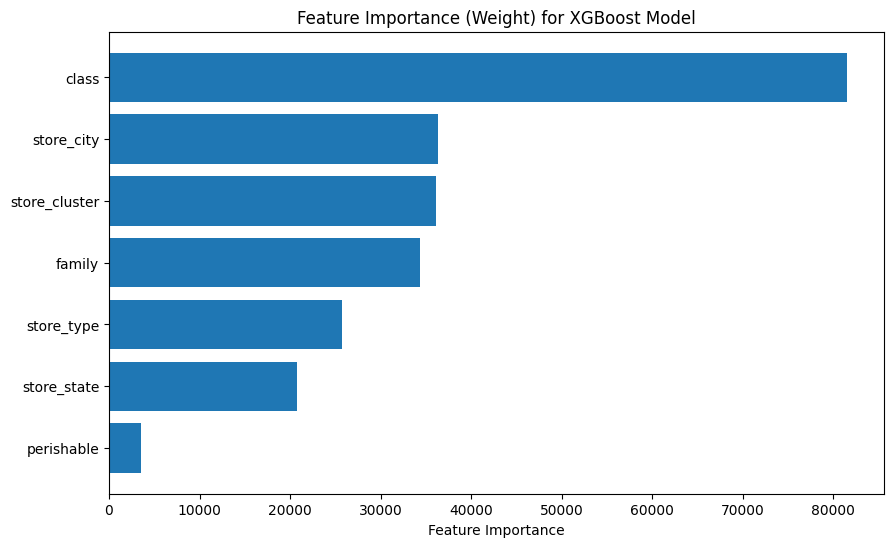

In [73]:
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Weight) for XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

# BASELINE 3 - LightGBM Model

In [73]:
import lightgbm as lgb
import numpy as np

steps = y_train.shape[1]
models = []

total_mse, total_rmse, total_mae, total_nwrmsle = 0, 0, 0, 0

for i in range(steps):
    print(f"Step {i} _______________")

    y_train_i = np.array(y_train[:, i]).ravel()
    y_val_i = np.array(y_val[:, i]).ravel()
    y_test_i = np.array(y_test[:, i]).ravel()

    dtrain = lgb.Dataset(X_train, label=y_train_i)
    dval = lgb.Dataset(X_val, label=y_val_i, reference=dtrain)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda_l1': 0.01,
        'lambda_l2': 0.01,
        'verbose': -1
    }

    num_round = 300
    model = lgb.train(params, dtrain, num_boost_round=num_round, 
                      valid_sets=[dtrain, dval],
                      callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])
    models.append(model)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    weights = items_data_indexed["perishable"].values * 0.25 + 1
    mse, rmse, mae, nwrmsle = cal_error(y_val_i, y_pred_val, weights)
    print(f'Target {i+1} Validation NWRMSLE: {nwrmsle}')
    print(f'Target {i+1} Validation MSE: {mse}')
    print(f'Target {i+1} Validation RMSE: {rmse}')
    print(f'Target {i+1} Validation MAE: {mae}')

    _, _, _, nwrmsle_test = cal_error(y_test_i, y_pred_test, weights)
    mse_test, rmse_test, mae_test, _ = cal_error(np.clip(np.expm1(y_test_i), 0, 1000), np.clip(np.expm1(y_pred_test), 0, 1000), weights)
    print(f'Target {i+1} Test NWRMSLE: {nwrmsle_test}')
    print(f'Target {i+1} Test MSE: {mse_test}')
    print(f'Target {i+1} Test RMSE: {rmse_test}')
    print(f'Target {i+1} Test MAE: {mae_test}')
    
    total_mse += mse_test
    total_rmse += rmse_test
    total_mae += mae_test
    total_nwrmsle += nwrmsle_test   

    feature_importance = model.feature_importance(importance_type='split')
    feature_names = X_train.columns
    importance_dict = dict(zip(feature_names, feature_importance))
    print(f'Target {i+1} Feature Importance:')
    print(importance_dict)

    model.save_model(f'lightgbm_baseline_model_target_{i+1}.txt')

total_mse /= steps
total_rmse /= steps
total_mae /= steps
total_nwrmsle /= steps

print("\nFinal Combined Test Metrics:")
print(f'Overall Validation NWRMSLE: {total_nwrmsle}')
print(f'Overall Validation MSE: {total_mse}')
print(f'Overall Validation RMSE: {total_rmse}')
print(f'Overall Validation MAE: {total_mae}')

Step 0 _______________
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.05169	valid_1's rmse: 0.961605
[100]	training's rmse: 1.04207	valid_1's rmse: 0.953511
[150]	training's rmse: 1.0381	valid_1's rmse: 0.950624
[200]	training's rmse: 1.03611	valid_1's rmse: 0.949282
[250]	training's rmse: 1.03475	valid_1's rmse: 0.948421
[300]	training's rmse: 1.03352	valid_1's rmse: 0.947506
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 1.03352	valid_1's rmse: 0.947506
Target 1 Validation NWRMSLE: 0.95194044870053
Target 1 Validation MSE: 0.9061906178721664
Target 1 Validation RMSE: 0.95194044870053
Target 1 Validation MAE: 0.7669722227621147
Target 1 Test NWRMSLE: 1.0822363679886593
Target 1 Test MSE: 359.5609813206091
Target 1 Test RMSE: 18.96209327370291
Target 1 Test MAE: 6.131853706807588
Target 1 Feature Importance:
{'family': np.int32(945), 'class': np.int32(3564), 'perishable': np.int32(127), 'store_type': np.int32(1257), 'store_c

## Load Extended Dataset

In [10]:
train_start_date = date(2017, 5, 8)
val_start_date = date(2017, 7, 10)
test_start_date = date(2017, 7, 31)

X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days = 7 * i)
    X_tmp, y_tmp = get_extended_dataset(train_start_date + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

X_val, y_val = get_extended_dataset(start_date=val_start_date, num_days=14)
X_test, y_test = get_extended_dataset(start_date=test_start_date, num_days=14)

# Improved XGBoost Model

In [78]:
import xgboost as xgb
import numpy as np

num_targets = y_train.shape[1]
models = []

total_mse, total_rmse, total_mae, total_nwrmsle = 0, 0, 0, 0

for i in range(num_targets):

    print(f"Step {i} _______________")

    y_train_i = np.array(y_train[:, i]).ravel()
    y_val_i = np.array(y_val[:, i]).ravel()
    y_test_i = np.array(y_test[:, i]).ravel()

    dtrain = xgb.DMatrix(X_train, label=y_train_i)
    dval = xgb.DMatrix(X_val, label=y_val_i)
    dtest = xgb.DMatrix(X_test, label=y_test_i)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'alpha': 0.01,
        'lambda': 0.01,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    num_round = 300
    model = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=50, verbose_eval=50)
    models.append(model)

    y_pred_val = model.predict(dval)
    y_pred_test = model.predict(dtest)
    
    weights = items_data_indexed["perishable"].values * 0.25 + 1
    mse, rmse, mae, nwrmsle = cal_error(y_val_i, y_pred_val, weights)
    print(f'Target {i+1} Validation NWRMSLE: {nwrmsle}')
    print(f'Target {i+1} Validation MSE: {mse}')
    print(f'Target {i+1} Validation RMSE: {rmse}')
    print(f'Target {i+1} Validation MAE: {mae}')

    _, _, _, nwrmsle_test = cal_error(y_test_i, y_pred_test, weights)
    mse_test, rmse_test, mae_test, _ = cal_error(np.clip(np.expm1(y_test_i), 0, 1000), np.clip(np.expm1(y_pred_test), 0, 1000), weights)
    print(f'Target {i+1} Test NWRMSLE: {nwrmsle_test}')
    print(f'Target {i+1} Test MSE: {mse_test}')
    print(f'Target {i+1} Test RMSE: {rmse_test}')
    print(f'Target {i+1} Test MAE: {mae_test}')
    
    total_mse += mse_test
    total_rmse += rmse_test
    total_mae += mae_test
    total_nwrmsle += nwrmsle_test   

    feature_importance = model.get_score(importance_type='weight')
    print(f'Target {i+1} Feature Importance:')
    print(feature_importance)

    model.save_model(f'xgboost_improved_model_target_{i+1}.model')

total_mse /= num_targets
total_rmse /= num_targets
total_mae /= num_targets
total_nwrmsle /= num_targets

print("\nFinal Combined Test Metrics:")
print(f'Overall Validation NWRMSLE: {total_nwrmsle}')
print(f'Overall Validation MSE: {total_mse}')
print(f'Overall Validation RMSE: {total_rmse}')
print(f'Overall Validation MAE: {total_mae}')

Step 0 _______________


C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.07523	val-rmse:1.07256
[50]	train-rmse:0.57343	val-rmse:0.56429
[100]	train-rmse:0.56970	val-rmse:0.56287
[150]	train-rmse:0.56710	val-rmse:0.56247
[200]	train-rmse:0.56496	val-rmse:0.56229
[250]	train-rmse:0.56292	val-rmse:0.56212
[299]	train-rmse:0.56128	val-rmse:0.56204
Target 1 Validation NWRMSLE: 0.5633287213069865
Target 1 Validation MSE: 0.31733924824936455
Target 1 Validation RMSE: 0.5633287213069865
Target 1 Validation MAE: 0.4030441473651482
Target 1 Test NWRMSLE: 0.5762769751855532
Target 1 Test MSE: 122.6491876607794
Target 1 Test RMSE: 11.07470937139117
Target 1 Test MAE: 2.5712382768024873
Target 1 Feature Importance:
{'family': 674.0, 'class': 1372.0, 'perishable': 92.0, 'store_type': 433.0, 'store_city': 386.0, 'store_cluster': 500.0, 'store_state': 302.0, 'day_1': 1543.0, 'mean_3': 1599.0, 'mean_7': 1455.0, 'mean_14': 1176.0, 'mean_4_dow0_sales': 1210.0, 'mean_4_dow1_sales': 1004.0, 'mean_4_dow2_sales': 901.0, 'mean_4_dow3_sales': 914.0, 'mean_4_dow4_s

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.05110	val-rmse:1.03233
[50]	train-rmse:0.58280	val-rmse:0.57842
[100]	train-rmse:0.57911	val-rmse:0.57729
[150]	train-rmse:0.57642	val-rmse:0.57680
[200]	train-rmse:0.57429	val-rmse:0.57643
[250]	train-rmse:0.57222	val-rmse:0.57621
[299]	train-rmse:0.57046	val-rmse:0.57619
Target 2 Validation NWRMSLE: 0.577365458877918
Target 2 Validation MSE: 0.3333508731053088
Target 2 Validation RMSE: 0.577365458877918
Target 2 Validation MAE: 0.4129124207592396
Target 2 Test NWRMSLE: 0.6316316293147569
Target 2 Test MSE: 194.0319974282233
Target 2 Test RMSE: 13.929536870557587
Target 2 Test MAE: 3.1856662064472983
Target 2 Feature Importance:
{'family': 782.0, 'class': 1260.0, 'perishable': 111.0, 'store_type': 487.0, 'store_city': 466.0, 'store_cluster': 441.0, 'store_state': 252.0, 'day_1': 1266.0, 'mean_3': 1556.0, 'mean_7': 1457.0, 'mean_14': 1276.0, 'mean_4_dow0_sales': 1019.0, 'mean_4_dow1_sales': 1317.0, 'mean_4_dow2_sales': 989.0, 'mean_4_dow3_sales': 951.0, 'mean_4_dow4_sa

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.06861	val-rmse:1.04035
[50]	train-rmse:0.58987	val-rmse:0.57756
[100]	train-rmse:0.58614	val-rmse:0.57672
[150]	train-rmse:0.58355	val-rmse:0.57633
[200]	train-rmse:0.58123	val-rmse:0.57617
[250]	train-rmse:0.57925	val-rmse:0.57612
[299]	train-rmse:0.57739	val-rmse:0.57611
Target 3 Validation NWRMSLE: 0.5765034556370464
Target 3 Validation MSE: 0.33235623436145595
Target 3 Validation RMSE: 0.5765034556370464
Target 3 Validation MAE: 0.41349401310575085
Target 3 Test NWRMSLE: 0.6189215892886654
Target 3 Test MSE: 184.40821719627863
Target 3 Test RMSE: 13.57969871522482
Target 3 Test MAE: 2.9979336235659773
Target 3 Feature Importance:
{'family': 814.0, 'class': 1249.0, 'perishable': 116.0, 'store_type': 532.0, 'store_city': 396.0, 'store_cluster': 513.0, 'store_state': 276.0, 'day_1': 1193.0, 'mean_3': 1624.0, 'mean_7': 1425.0, 'mean_14': 1245.0, 'mean_4_dow0_sales': 933.0, 'mean_4_dow1_sales': 1052.0, 'mean_4_dow2_sales': 1291.0, 'mean_4_dow3_sales': 1000.0, 'mean_4_do

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.00162	val-rmse:0.97450
[50]	train-rmse:0.59573	val-rmse:0.59672
[100]	train-rmse:0.59219	val-rmse:0.59604
[150]	train-rmse:0.58953	val-rmse:0.59554
[200]	train-rmse:0.58732	val-rmse:0.59530
[250]	train-rmse:0.58539	val-rmse:0.59520
[299]	train-rmse:0.58367	val-rmse:0.59520
Target 4 Validation NWRMSLE: 0.5951658150376781
Target 4 Validation MSE: 0.3542223473894636
Target 4 Validation RMSE: 0.5951658150376781
Target 4 Validation MAE: 0.42643695860785286
Target 4 Test NWRMSLE: 0.6125722901718405
Target 4 Test MSE: 87.70243245804316
Target 4 Test RMSE: 9.364957685865065
Target 4 Test MAE: 2.4173139067264207
Target 4 Feature Importance:
{'family': 638.0, 'class': 1404.0, 'perishable': 75.0, 'store_type': 374.0, 'store_city': 449.0, 'store_cluster': 406.0, 'store_state': 235.0, 'day_1': 1154.0, 'mean_3': 1613.0, 'mean_7': 1416.0, 'mean_14': 1383.0, 'mean_4_dow0_sales': 1029.0, 'mean_4_dow1_sales': 1011.0, 'mean_4_dow2_sales': 1057.0, 'mean_4_dow3_sales': 1225.0, 'mean_4_dow4

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.09828	val-rmse:1.05110
[50]	train-rmse:0.61368	val-rmse:0.61027
[100]	train-rmse:0.60904	val-rmse:0.60864
[150]	train-rmse:0.60585	val-rmse:0.60787
[200]	train-rmse:0.60349	val-rmse:0.60747
[250]	train-rmse:0.60150	val-rmse:0.60739
[299]	train-rmse:0.59964	val-rmse:0.60733
Target 5 Validation NWRMSLE: 0.6069742193755232
Target 5 Validation MSE: 0.3684177029865258
Target 5 Validation RMSE: 0.6069742193755232
Target 5 Validation MAE: 0.43467561053099985
Target 5 Test NWRMSLE: 0.6125911388891169
Target 5 Test MSE: 120.56494805390284
Target 5 Test RMSE: 10.980207104326531
Target 5 Test MAE: 2.596755719034647
Target 5 Feature Importance:
{'family': 695.0, 'class': 1566.0, 'perishable': 81.0, 'store_type': 527.0, 'store_city': 404.0, 'store_cluster': 414.0, 'store_state': 216.0, 'day_1': 1145.0, 'mean_3': 1618.0, 'mean_7': 1359.0, 'mean_14': 1400.0, 'mean_4_dow0_sales': 1037.0, 'mean_4_dow1_sales': 976.0, 'mean_4_dow2_sales': 1015.0, 'mean_4_dow3_sales': 1037.0, 'mean_4_dow4

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.21071	val-rmse:1.16098
[50]	train-rmse:0.61916	val-rmse:0.61925
[80]	train-rmse:0.61682	val-rmse:0.61916
Target 6 Validation NWRMSLE: 0.6180849106839756
Target 6 Validation MSE: 0.38202895681521815
Target 6 Validation RMSE: 0.6180849106839756
Target 6 Validation MAE: 0.43938463010692647
Target 6 Test NWRMSLE: 0.6157439841175318
Target 6 Test MSE: 90.39351627333117
Target 6 Test RMSE: 9.507550487550995
Target 6 Test MAE: 2.788768087195805
Target 6 Feature Importance:
{'family': 172.0, 'class': 474.0, 'perishable': 19.0, 'store_type': 172.0, 'store_city': 127.0, 'store_cluster': 106.0, 'store_state': 130.0, 'day_1': 368.0, 'mean_3': 564.0, 'mean_7': 350.0, 'mean_14': 405.0, 'mean_4_dow0_sales': 266.0, 'mean_4_dow1_sales': 171.0, 'mean_4_dow2_sales': 201.0, 'mean_4_dow3_sales': 227.0, 'mean_4_dow4_sales': 286.0, 'mean_4_dow5_sales': 448.0, 'mean_4_dow6_sales': 294.0}
Step 6 _______________


C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.23270	val-rmse:1.22132
[50]	train-rmse:0.63121	val-rmse:0.62954
[100]	train-rmse:0.62658	val-rmse:0.62804
[150]	train-rmse:0.62338	val-rmse:0.62795
[184]	train-rmse:0.62153	val-rmse:0.62796
Target 7 Validation NWRMSLE: 0.6271409554560369
Target 7 Validation MSE: 0.39330577801031086
Target 7 Validation RMSE: 0.6271409554560369
Target 7 Validation MAE: 0.4475254876449036
Target 7 Test NWRMSLE: 0.6236638886818421
Target 7 Test MSE: 111.59917350150057
Target 7 Test RMSE: 10.564050998622667
Target 7 Test MAE: 2.9891358215394805
Target 7 Feature Importance:
{'family': 430.0, 'class': 1020.0, 'perishable': 56.0, 'store_type': 351.0, 'store_city': 359.0, 'store_cluster': 323.0, 'store_state': 214.0, 'day_1': 874.0, 'mean_3': 1054.0, 'mean_7': 924.0, 'mean_14': 710.0, 'mean_4_dow0_sales': 630.0, 'mean_4_dow1_sales': 582.0, 'mean_4_dow2_sales': 534.0, 'mean_4_dow3_sales': 459.0, 'mean_4_dow4_sales': 527.0, 'mean_4_dow5_sales': 596.0, 'mean_4_dow6_sales': 812.0}
Step 7 __________

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.08140	val-rmse:1.08901
[50]	train-rmse:0.61729	val-rmse:0.62356
[100]	train-rmse:0.61323	val-rmse:0.62295
[150]	train-rmse:0.61055	val-rmse:0.62274
[200]	train-rmse:0.60834	val-rmse:0.62274
[250]	train-rmse:0.60624	val-rmse:0.62277
[273]	train-rmse:0.60528	val-rmse:0.62276
Target 8 Validation NWRMSLE: 0.6231104315888177
Target 8 Validation MSE: 0.3882666099548028
Target 8 Validation RMSE: 0.6231104315888177
Target 8 Validation MAE: 0.4475072647571423
Target 8 Test NWRMSLE: 0.6203587677681055
Target 8 Test MSE: 84.60547437457252
Target 8 Test RMSE: 9.19812341592417
Target 8 Test MAE: 2.524284592355385
Target 8 Feature Importance:
{'family': 647.0, 'class': 1482.0, 'perishable': 87.0, 'store_type': 361.0, 'store_city': 335.0, 'store_cluster': 404.0, 'store_state': 254.0, 'day_1': 1113.0, 'mean_3': 1366.0, 'mean_7': 1252.0, 'mean_14': 1173.0, 'mean_4_dow0_sales': 1199.0, 'mean_4_dow1_sales': 1032.0, 'mean_4_dow2_sales': 910.0, 'mean_4_dow3_sales': 889.0, 'mean_4_dow4_sale

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.06079	val-rmse:1.03888
[50]	train-rmse:0.61637	val-rmse:0.62124
[100]	train-rmse:0.61265	val-rmse:0.62088
[150]	train-rmse:0.60986	val-rmse:0.62073
[200]	train-rmse:0.60740	val-rmse:0.62064
[248]	train-rmse:0.60538	val-rmse:0.62081
Target 9 Validation NWRMSLE: 0.6212104208721028
Target 9 Validation MSE: 0.385902387000095
Target 9 Validation RMSE: 0.6212104208721028
Target 9 Validation MAE: 0.4452898049401812
Target 9 Test NWRMSLE: 0.6141805021457051
Target 9 Test MSE: 77.73261185670727
Target 9 Test RMSE: 8.816609997992838
Target 9 Test MAE: 2.3247405074346155
Target 9 Feature Importance:
{'family': 735.0, 'class': 1251.0, 'perishable': 90.0, 'store_type': 435.0, 'store_city': 335.0, 'store_cluster': 373.0, 'store_state': 219.0, 'day_1': 956.0, 'mean_3': 1279.0, 'mean_7': 1218.0, 'mean_14': 1061.0, 'mean_4_dow0_sales': 920.0, 'mean_4_dow1_sales': 1068.0, 'mean_4_dow2_sales': 814.0, 'mean_4_dow3_sales': 811.0, 'mean_4_dow4_sales': 757.0, 'mean_4_dow5_sales': 725.0, 'mea

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.07287	val-rmse:1.05281
[50]	train-rmse:0.61846	val-rmse:0.62187
[100]	train-rmse:0.61471	val-rmse:0.62099
[150]	train-rmse:0.61171	val-rmse:0.62084
[200]	train-rmse:0.60942	val-rmse:0.62066
[250]	train-rmse:0.60717	val-rmse:0.62075
[253]	train-rmse:0.60703	val-rmse:0.62074
Target 10 Validation NWRMSLE: 0.6205580107668613
Target 10 Validation MSE: 0.38509224472692394
Target 10 Validation RMSE: 0.6205580107668613
Target 10 Validation MAE: 0.44478595980189906
Target 10 Test NWRMSLE: 0.6119276805157468
Target 10 Test MSE: 74.85352711815723
Target 10 Test RMSE: 8.651793289148628
Target 10 Test MAE: 2.3366514575035366
Target 10 Feature Importance:
{'family': 750.0, 'class': 1237.0, 'perishable': 99.0, 'store_type': 488.0, 'store_city': 325.0, 'store_cluster': 403.0, 'store_state': 203.0, 'day_1': 891.0, 'mean_3': 1299.0, 'mean_7': 1238.0, 'mean_14': 1183.0, 'mean_4_dow0_sales': 914.0, 'mean_4_dow1_sales': 927.0, 'mean_4_dow2_sales': 1126.0, 'mean_4_dow3_sales': 823.0, 'mean_

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.00186	val-rmse:1.01774
[50]	train-rmse:0.61463	val-rmse:0.61932
[100]	train-rmse:0.61075	val-rmse:0.61858
[150]	train-rmse:0.60808	val-rmse:0.61858
[200]	train-rmse:0.60570	val-rmse:0.61855
[214]	train-rmse:0.60518	val-rmse:0.61859
Target 11 Validation NWRMSLE: 0.6181445796866046
Target 11 Validation MSE: 0.38210272139592916
Target 11 Validation RMSE: 0.6181445796866046
Target 11 Validation MAE: 0.4481701872802823
Target 11 Test NWRMSLE: 0.6165290777251291
Target 11 Test MSE: 86.3803491957878
Target 11 Test RMSE: 9.294102925822793
Target 11 Test MAE: 2.241575832419469
Target 11 Feature Importance:
{'family': 532.0, 'class': 1102.0, 'perishable': 76.0, 'store_type': 260.0, 'store_city': 301.0, 'store_cluster': 291.0, 'store_state': 156.0, 'day_1': 785.0, 'mean_3': 1151.0, 'mean_7': 1015.0, 'mean_14': 1095.0, 'mean_4_dow0_sales': 765.0, 'mean_4_dow1_sales': 770.0, 'mean_4_dow2_sales': 764.0, 'mean_4_dow3_sales': 928.0, 'mean_4_dow4_sales': 705.0, 'mean_4_dow5_sales': 724

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.10117	val-rmse:1.06037
[50]	train-rmse:0.63467	val-rmse:0.62776
[100]	train-rmse:0.63037	val-rmse:0.62708
[150]	train-rmse:0.62719	val-rmse:0.62665
[200]	train-rmse:0.62463	val-rmse:0.62660
[250]	train-rmse:0.62243	val-rmse:0.62655
[284]	train-rmse:0.62103	val-rmse:0.62660
Target 12 Validation NWRMSLE: 0.6262500118596966
Target 12 Validation MSE: 0.39218907735427017
Target 12 Validation RMSE: 0.6262500118596966
Target 12 Validation MAE: 0.45120874495194757
Target 12 Test NWRMSLE: 0.6384261078578239
Target 12 Test MSE: 107.69027355474597
Target 12 Test RMSE: 10.377392425592566
Target 12 Test MAE: 2.669475051608406
Target 12 Feature Importance:
{'family': 699.0, 'class': 1593.0, 'perishable': 122.0, 'store_type': 535.0, 'store_city': 379.0, 'store_cluster': 409.0, 'store_state': 227.0, 'day_1': 911.0, 'mean_3': 1492.0, 'mean_7': 1294.0, 'mean_14': 1314.0, 'mean_4_dow0_sales': 918.0, 'mean_4_dow1_sales': 998.0, 'mean_4_dow2_sales': 970.0, 'mean_4_dow3_sales': 953.0, 'mean

C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.20215	val-rmse:1.14272
[50]	train-rmse:0.63987	val-rmse:0.63981
[78]	train-rmse:0.63731	val-rmse:0.63975
Target 13 Validation NWRMSLE: 0.6386541668331336
Target 13 Validation MSE: 0.40787914481332405
Target 13 Validation RMSE: 0.6386541668331336
Target 13 Validation MAE: 0.45785429632476893
Target 13 Test NWRMSLE: 0.6405825480178681
Target 13 Test MSE: 108.04624911166763
Target 13 Test RMSE: 10.39452976866523
Target 13 Test MAE: 2.5600959053914805
Target 13 Feature Importance:
{'family': 180.0, 'class': 508.0, 'perishable': 44.0, 'store_type': 175.0, 'store_city': 145.0, 'store_cluster': 99.0, 'store_state': 120.0, 'day_1': 393.0, 'mean_3': 496.0, 'mean_7': 358.0, 'mean_14': 376.0, 'mean_4_dow0_sales': 258.0, 'mean_4_dow1_sales': 208.0, 'mean_4_dow2_sales': 217.0, 'mean_4_dow3_sales': 196.0, 'mean_4_dow4_sales': 246.0, 'mean_4_dow5_sales': 393.0, 'mean_4_dow6_sales': 292.0}
Step 13 _______________


C:\Users\CSamarajeewa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:1.24966	val-rmse:1.18706
[50]	train-rmse:0.65184	val-rmse:0.64766
[78]	train-rmse:0.64838	val-rmse:0.64866
Target 14 Validation NWRMSLE: 0.6479118770487472
Target 14 Validation MSE: 0.41978980042083086
Target 14 Validation RMSE: 0.6479118770487472
Target 14 Validation MAE: 0.46480203939288567
Target 14 Test NWRMSLE: 0.638604706847995
Target 14 Test MSE: 103.77989000250729
Target 14 Test RMSE: 10.187241530586546
Target 14 Test MAE: 2.691031251673653
Target 14 Feature Importance:
{'family': 185.0, 'class': 618.0, 'perishable': 42.0, 'store_type': 233.0, 'store_city': 176.0, 'store_cluster': 183.0, 'store_state': 124.0, 'day_1': 415.0, 'mean_3': 411.0, 'mean_7': 347.0, 'mean_14': 313.0, 'mean_4_dow0_sales': 353.0, 'mean_4_dow1_sales': 251.0, 'mean_4_dow2_sales': 189.0, 'mean_4_dow3_sales': 152.0, 'mean_4_dow4_sales': 156.0, 'mean_4_dow5_sales': 256.0, 'mean_4_dow6_sales': 417.0}

Final Combined Test Metrics:
Overall Validation NWRMSLE: 0.6194293490376914
Overall Validation 

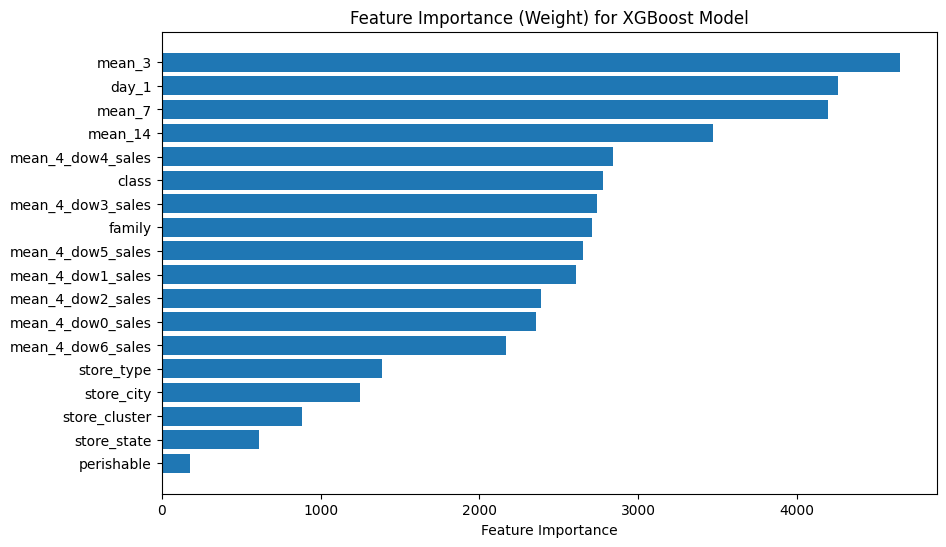

In [23]:
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Weight) for XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

# Improved LightGBM Model

In [17]:
import lightgbm as lgb
import numpy as np

steps = y_train.shape[1]
models = []

total_mse, total_rmse, total_mae, total_nwrmsle = 0, 0, 0, 0

for i in range(steps):
    print(f"Step {i} _______________")

    y_train_i = np.array(y_train[:, i]).ravel()
    y_val_i = np.array(y_val[:, i]).ravel()
    y_test_i = np.array(y_test[:, i]).ravel()

    dtrain = lgb.Dataset(X_train, label=y_train_i)
    dval = lgb.Dataset(X_val, label=y_val_i, reference=dtrain)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda_l1': 0.01,
        'lambda_l2': 0.01,
        'verbose': -1
    }

    num_round = 300
    model = lgb.train(params, dtrain, num_boost_round=num_round, 
                      valid_sets=[dtrain, dval],
                      callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])
    models.append(model)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    weights = items_data_indexed["perishable"].values * 0.25 + 1
    mse, rmse, mae, nwrmsle = cal_error(y_val_i, y_pred_val, weights)
    print(f'Target {i+1} Validation NWRMSLE: {nwrmsle}')
    print(f'Target {i+1} Validation MSE: {mse}')
    print(f'Target {i+1} Validation RMSE: {rmse}')
    print(f'Target {i+1} Validation MAE: {mae}')

    _, _, _, nwrmsle_test = cal_error(y_test_i, y_pred_test, weights)
    mse_test, rmse_test, mae_test, _ = cal_error(np.clip(np.expm1(y_test_i), 0, 1000), np.clip(np.expm1(y_pred_test), 0, 1000), weights)
    print(f'Target {i+1} Test NWRMSLE: {nwrmsle_test}')
    print(f'Target {i+1} Test MSE: {mse_test}')
    print(f'Target {i+1} Test RMSE: {rmse_test}')
    print(f'Target {i+1} Test MAE: {mae_test}')
    
    total_mse += mse_test
    total_rmse += rmse_test
    total_mae += mae_test
    total_nwrmsle += nwrmsle_test   

    feature_importance = model.feature_importance(importance_type='split')
    feature_names = X_train.columns
    importance_dict = dict(zip(feature_names, feature_importance))
    print(f'Target {i+1} Feature Importance:')
    print(importance_dict)

    model.save_model(f'lightgbm_improved_model_target_{i+1}.txt')

total_mse /= steps
total_rmse /= steps
total_mae /= steps
total_nwrmsle /= steps

print("\nFinal Combined Test Metrics:")
print(f'Overall Validation NWRMSLE: {total_nwrmsle}')
print(f'Overall Validation MSE: {total_mse}')
print(f'Overall Validation RMSE: {total_rmse}')
print(f'Overall Validation MAE: {total_mae}')

Step 0 _______________
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.576263	valid_1's rmse: 0.565285
[100]	training's rmse: 0.572732	valid_1's rmse: 0.563543
[150]	training's rmse: 0.570662	valid_1's rmse: 0.562779
[200]	training's rmse: 0.569027	valid_1's rmse: 0.562423
[250]	training's rmse: 0.567621	valid_1's rmse: 0.562246
[300]	training's rmse: 0.566367	valid_1's rmse: 0.562069
Did not meet early stopping. Best iteration is:
[291]	training's rmse: 0.566563	valid_1's rmse: 0.562049
Target 1 Validation NWRMSLE: 0.5633251194434669
Target 1 Validation MSE: 0.31733519019599626
Target 1 Validation RMSE: 0.5633251194434669
Target 1 Validation MAE: 0.4032463706190959
Target 1 Test NWRMSLE: 0.5763087119263364
Target 1 Test MSE: 128.05178443901073
Target 1 Test RMSE: 11.315996838061185
Target 1 Test MAE: 2.598500214377816
Target 1 Feature Importance:
{'family': np.int32(260), 'class': np.int32(860), 'perishable': np.int32(65), 'store_type': np.int32(16

In [23]:
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1])
sorted_importance

[('mean_4_dow4_sales', np.int32(4)),
 ('mean_4_dow3_sales', np.int32(8)),
 ('perishable', np.int32(15)),
 ('mean_4_dow2_sales', np.int32(15)),
 ('family', np.int32(37)),
 ('mean_4_dow1_sales', np.int32(46)),
 ('store_city', np.int32(49)),
 ('store_cluster', np.int32(52)),
 ('store_state', np.int32(52)),
 ('mean_14', np.int32(54)),
 ('mean_4_dow5_sales', np.int32(72)),
 ('mean_3', np.int32(80)),
 ('mean_7', np.int32(87)),
 ('store_type', np.int32(92)),
 ('class', np.int32(121)),
 ('day_1', np.int32(129)),
 ('mean_4_dow0_sales', np.int32(129)),
 ('mean_4_dow6_sales', np.int32(158))]

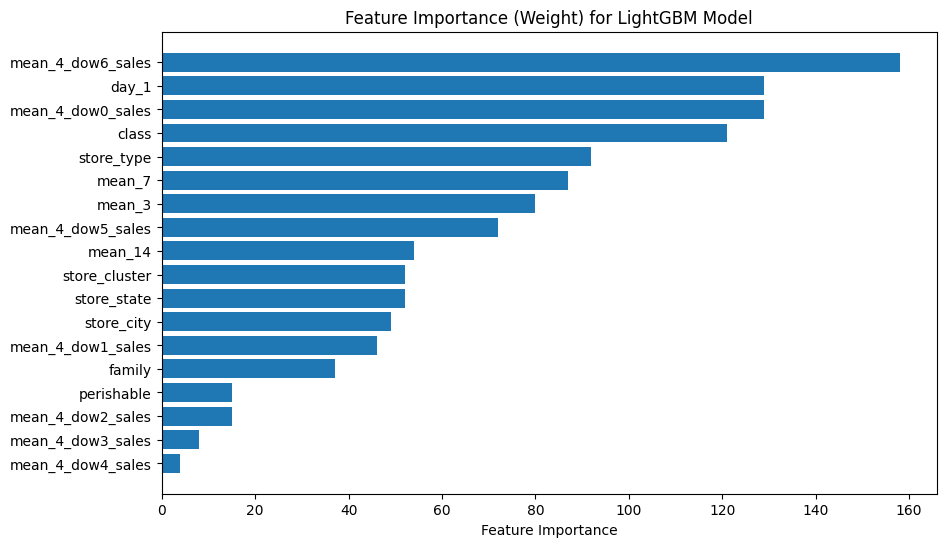

In [25]:
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

features, importance = [item[0] for item in sorted_importance], [item[1] for item in sorted_importance]

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Weight) for LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

## LSTM Model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_targets):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_targets)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        return self.fc(lstm_out)

input_size = 1  
hidden_size = 16
num_layers = 2
num_targets = 14 
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reshape_for_lstm(X):
    return np.expand_dims(X, axis=-1)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = reshape_for_lstm(X_train_scaled)
X_val_lstm = reshape_for_lstm(X_val_scaled)
X_test_lstm = reshape_for_lstm(X_test_scaled)

X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_lstm, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [12]:
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_targets).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)


for epoch in range(epochs):
    lstm_model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = lstm_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

lstm_model.eval()
with torch.no_grad():
    y_pred_val = lstm_model(X_val_tensor).cpu().detach()
    y_pred_test = lstm_model(X_test_tensor).cpu().detach()

weights = items_data_indexed["perishable"].values * 0.25 + 1
mse_val, rmse_val, mae_val, nwrmsle_val = cal_error(y_val, y_pred_val, weights)
_, _, _, nwrmsle_test = cal_error(y_test, y_pred_test, weights)
mse_test, rmse_test, mae_test, _ = cal_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(y_pred_test), 0, 1000), weights)

print(f'Validation NWRMSLE: {nwrmsle_val}')
print(f'Validation MSE: {mse_val}')
print(f'Validation RMSE: {rmse_val}')
print(f'Validation MAE: {mae_val}')

print(f'Test NWRMSLE: {nwrmsle_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')

torch.save(lstm_model.state_dict(), "lstm_model.pth")


100%|██████████| 65507/65507 [02:11<00:00, 498.93it/s]


Epoch 1/50, Loss: 0.4141


100%|██████████| 65507/65507 [02:09<00:00, 504.07it/s]


Epoch 2/50, Loss: 0.4054


100%|██████████| 65507/65507 [02:09<00:00, 505.49it/s]


Epoch 3/50, Loss: 0.4040


100%|██████████| 65507/65507 [02:09<00:00, 504.06it/s]


Epoch 4/50, Loss: 0.4032


100%|██████████| 65507/65507 [02:09<00:00, 505.50it/s]


Epoch 5/50, Loss: 0.4025


100%|██████████| 65507/65507 [02:17<00:00, 476.01it/s]


Epoch 6/50, Loss: 0.4020


100%|██████████| 65507/65507 [02:16<00:00, 480.53it/s]


Epoch 7/50, Loss: 0.4017


100%|██████████| 65507/65507 [02:16<00:00, 481.54it/s]


Epoch 8/50, Loss: 0.4015


100%|██████████| 65507/65507 [02:11<00:00, 497.59it/s]


Epoch 9/50, Loss: 0.4013


100%|██████████| 65507/65507 [02:09<00:00, 505.82it/s]


Epoch 10/50, Loss: 0.4009


100%|██████████| 65507/65507 [02:09<00:00, 505.86it/s]


Epoch 11/50, Loss: 0.4008


100%|██████████| 65507/65507 [02:18<00:00, 473.88it/s]


Epoch 12/50, Loss: 0.4005


100%|██████████| 65507/65507 [02:14<00:00, 488.14it/s]


Epoch 13/50, Loss: 0.4003


100%|██████████| 65507/65507 [02:13<00:00, 489.88it/s]


Epoch 14/50, Loss: 0.4001


100%|██████████| 65507/65507 [02:23<00:00, 457.99it/s]


Epoch 15/50, Loss: 0.4000


100%|██████████| 65507/65507 [02:11<00:00, 497.09it/s]


Epoch 16/50, Loss: 0.3998


100%|██████████| 65507/65507 [02:12<00:00, 494.15it/s]


Epoch 17/50, Loss: 0.3997


100%|██████████| 65507/65507 [02:15<00:00, 483.39it/s]


Epoch 18/50, Loss: 0.3996


100%|██████████| 65507/65507 [02:14<00:00, 485.50it/s]


Epoch 19/50, Loss: 0.3994


100%|██████████| 65507/65507 [02:13<00:00, 489.20it/s]


Epoch 20/50, Loss: 0.3993


100%|██████████| 65507/65507 [02:12<00:00, 494.83it/s]


Epoch 21/50, Loss: 0.3993


100%|██████████| 65507/65507 [02:13<00:00, 490.65it/s]


Epoch 22/50, Loss: 0.3992


100%|██████████| 65507/65507 [02:12<00:00, 492.54it/s]


Epoch 23/50, Loss: 0.3991


100%|██████████| 65507/65507 [02:09<00:00, 506.67it/s]


Epoch 24/50, Loss: 0.3991


100%|██████████| 65507/65507 [02:10<00:00, 503.58it/s]


Epoch 25/50, Loss: 0.3989


100%|██████████| 65507/65507 [02:10<00:00, 501.10it/s]


Epoch 26/50, Loss: 0.3988


100%|██████████| 65507/65507 [02:12<00:00, 493.17it/s]


Epoch 27/50, Loss: 0.3985


100%|██████████| 65507/65507 [02:12<00:00, 494.64it/s]


Epoch 28/50, Loss: 0.3986


100%|██████████| 65507/65507 [02:12<00:00, 494.18it/s]


Epoch 29/50, Loss: 0.3987


100%|██████████| 65507/65507 [02:10<00:00, 500.31it/s]


Epoch 30/50, Loss: 0.3985


100%|██████████| 65507/65507 [02:12<00:00, 494.14it/s]


Epoch 31/50, Loss: 0.3985


100%|██████████| 65507/65507 [02:14<00:00, 486.00it/s]


Epoch 32/50, Loss: 0.3984


100%|██████████| 65507/65507 [02:16<00:00, 479.18it/s]


Epoch 33/50, Loss: 0.3984


100%|██████████| 65507/65507 [02:14<00:00, 486.47it/s]


Epoch 34/50, Loss: 0.3984


100%|██████████| 65507/65507 [02:14<00:00, 486.65it/s]


Epoch 35/50, Loss: 0.3984


100%|██████████| 65507/65507 [02:17<00:00, 477.93it/s]


Epoch 36/50, Loss: 0.3983


100%|██████████| 65507/65507 [02:16<00:00, 479.89it/s]


Epoch 37/50, Loss: 0.3983


100%|██████████| 65507/65507 [02:15<00:00, 482.19it/s]


Epoch 38/50, Loss: 0.3982


100%|██████████| 65507/65507 [02:13<00:00, 489.18it/s]


Epoch 39/50, Loss: 0.3981


100%|██████████| 65507/65507 [02:16<00:00, 479.15it/s]


Epoch 40/50, Loss: 0.3981


100%|██████████| 65507/65507 [02:15<00:00, 484.75it/s]


Epoch 41/50, Loss: 0.3981


100%|██████████| 65507/65507 [02:16<00:00, 479.39it/s]


Epoch 42/50, Loss: 0.3980


100%|██████████| 65507/65507 [02:14<00:00, 485.65it/s]


Epoch 43/50, Loss: 0.3980


100%|██████████| 65507/65507 [02:15<00:00, 481.88it/s]


Epoch 44/50, Loss: 0.3980


100%|██████████| 65507/65507 [02:16<00:00, 478.97it/s]


Epoch 45/50, Loss: 0.3979


100%|██████████| 65507/65507 [02:15<00:00, 482.26it/s]


Epoch 46/50, Loss: 0.3978


100%|██████████| 65507/65507 [02:16<00:00, 480.57it/s]


Epoch 47/50, Loss: 0.3980


100%|██████████| 65507/65507 [02:14<00:00, 486.06it/s]


Epoch 48/50, Loss: 0.3978


100%|██████████| 65507/65507 [02:16<00:00, 479.18it/s]


Epoch 49/50, Loss: 0.3977


100%|██████████| 65507/65507 [2:33:42<00:00,  7.10it/s] 


Epoch 50/50, Loss: 0.3978
Validation NWRMSLE: 0.614659817881942
Validation MSE: 0.37780669171866216
Validation RMSE: 0.614659817881942
Validation MAE: 0.44347411595426783
Test NWRMSLE: 0.6227524895336325
Test MSE: 113.16173536062163
Test RMSE: 10.637750484036633
Test MAE: 2.6817606138710235


# Stacked Ensemble Model

In [17]:
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_targets).to(device)
lstm_model.load_state_dict(torch.load("lstm_model.pth", map_location=device))
lstm_model.eval()

X_val_tensor = torch.tensor(reshape_for_lstm(X_val_scaled), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(reshape_for_lstm(X_test_scaled), dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred_val_lstm = lstm_model(X_val_tensor).cpu().numpy()
    y_pred_test_lstm = lstm_model(X_test_tensor).cpu().numpy()

nwrmsle_vals, mse_vals, rmse_vals, mae_vals = [], [], [], []

for i in tqdm(range(num_targets)):
    xgb_model = xgb.Booster()
    xgb_model.load_model(f"xgboost_improved_model_target_{i+1}.model")
    
    lgb_model = lgb.Booster(model_file=f"lightgbm_improved_model_target_{i+1}.txt")
    
    y_pred_val_xgb = xgb_model.predict(xgb.DMatrix(X_val))
    y_pred_test_xgb = xgb_model.predict(xgb.DMatrix(X_test))
    
    y_pred_val_lgb = lgb_model.predict(X_val)
    y_pred_test_lgb = lgb_model.predict(X_test)
    
    y_pred_val_all = np.column_stack([y_pred_val_xgb, y_pred_val_lgb, y_pred_val_lstm[:, i]])
    y_pred_test_all = np.column_stack([y_pred_test_xgb, y_pred_test_lgb, y_pred_test_lstm[:, i]])
    
    meta_model = Ridge(alpha=1.0)
    meta_model.fit(y_pred_val_all, y_val[:, i])
    
    y_pred_test_ensemble = meta_model.predict(y_pred_test_all)
    
    weights = items_data_indexed["perishable"].values * 0.25 + 1
    _, _, _, nwrmsle_test = cal_error(y_test[:, i], y_pred_test_ensemble, weights)
    mse_test, rmse_test, mae_test, _ = cal_error(np.clip(np.expm1(y_test[:, i]), 0, 1000),
                                                  np.clip(np.expm1(y_pred_test_ensemble), 0, 1000),
                                                  weights)
    
    nwrmsle_vals.append(nwrmsle_test)
    mse_vals.append(mse_test)
    rmse_vals.append(rmse_test)
    mae_vals.append(mae_test)

avg_nwrmsle, avg_mse, avg_rmse, avg_mae = map(np.mean, [nwrmsle_vals, mse_vals, rmse_vals, mae_vals])

print("\nFinal Combined Metrics:")
print(f'Average Test NWRMSLE: {avg_nwrmsle}')
print(f'Average Test MSE: {avg_mse}')
print(f'Average Test RMSE: {avg_rmse}')
print(f'Average Test MAE: {avg_mae}')


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


Final Combined Metrics:
Average Test NWRMSLE: 0.618222858708911
Average Test MSE: 110.95163453194873
Average Test RMSE: 10.416994461344625
Average Test MAE: 2.6388299440502294


## Analyze Predictions

In [13]:
time_steps = 200
store_type = 0
filtered_X_test = X_test[X_test["store_type"] == store_type].iloc[:time_steps]
filtered_y_test = y_test[X_test["store_type"] == store_type][:time_steps, 13]

xgb_model = xgb.Booster()
xgb_model.load_model(f"xgboost_improved_model_target_{13}.model")
    
lgb_model = lgb.Booster(model_file=f"lightgbm_improved_model_target_{13}.txt")

y_pred_test_xgb = xgb_model.predict(xgb.DMatrix(filtered_X_test))
y_pred_test_lgb = lgb_model.predict(filtered_X_test)

filtered_X_test_lstm = scaler.transform(filtered_X_test)
filtered_X_test_lstm = np.expand_dims(filtered_X_test_lstm, axis=-1)
filtered_X_test_tensor = torch.tensor(filtered_X_test_lstm, dtype=torch.float32).to(device)

lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_targets).to(device)
lstm_model.load_state_dict(torch.load("lstm_model.pth", map_location=device))

with torch.no_grad():
    y_pred_test_lstm = lstm_model(filtered_X_test_tensor).cpu().numpy()[:, 13]

filtered_y_test_transformed = np.expm1(filtered_y_test)
y_pred_test_xgb_transformed = np.expm1(y_pred_test_xgb)
y_pred_test_lgb_transformed = np.expm1(y_pred_test_lgb)
y_pred_test_lstm_transformed = np.expm1(y_pred_test_lstm)

plt.plot(filtered_y_test_transformed, label="Actual", color="black", linewidth=1)
plt.figure(figsize=(8, 4))
plt.plot(filtered_y_test_transformed, label="Actual", color="black", linewidth=1)
plt.plot(y_pred_test_xgb_transformed, label="XGBoost Predicted", color="blue", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Unit Sales")
plt.title("XGBoost Predictions vs Actual")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(filtered_y_test_transformed, label="Actual", color="black", linewidth=1)
plt.plot(y_pred_test_lgb_transformed, label="LightGBM Predicted", color="green", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Unit Sales")
plt.title("LightGBM Predictions vs Actual")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(filtered_y_test_transformed, label="Actual", color="black", linewidth=1)
plt.plot(y_pred_test_lstm_transformed, label="LSTM Predicted", color="red", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Unit Sales")
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()

In [141]:
stores_data_indexed

,city,state,type,cluster,type_encoded,city_encoded,state_encoded
store_nbr,,,,,,,
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
1,Quito,Pichincha,D,13,3,18,12
...,...,...,...,...,...,...,...
54,El Carmen,Manabi,C,3,2,5,10
54,El Carmen,Manabi,C,3,2,5,10
54,El Carmen,Manabi,C,3,2,5,10


In [167]:
y_test_df = pd.DataFrame(y_test[:, 13], columns=['y_test']) 
y_pred_test_lgb = pd.DataFrame(lgb_model.predict(X_test), columns=['y_test_pred'])

stores_data_indexed['y_test'] = np.expm1(y_test_df)
stores_data_indexed['y_test_pred'] = np.expm1(y_pred_test_lgb)

stores_data_indexed['squared_error'] = (stores_data_indexed['y_test'] - stores_data_indexed['y_test_pred'])**2

items_data_indexed['y_test'] = np.expm1(y_test_df)
items_data_indexed['y_test_pred'] = np.expm1(y_pred_test_lgb)

items_data_indexed['squared_error'] = (items_data_indexed['y_test'] - items_data_indexed['y_test_pred'])**2

C:\Users\CSamarajeewa\AppData\Local\Temp\ipykernel_21868\467349799.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='store_nbr', y='rmse', data=rmse_per_store, palette='viridis')


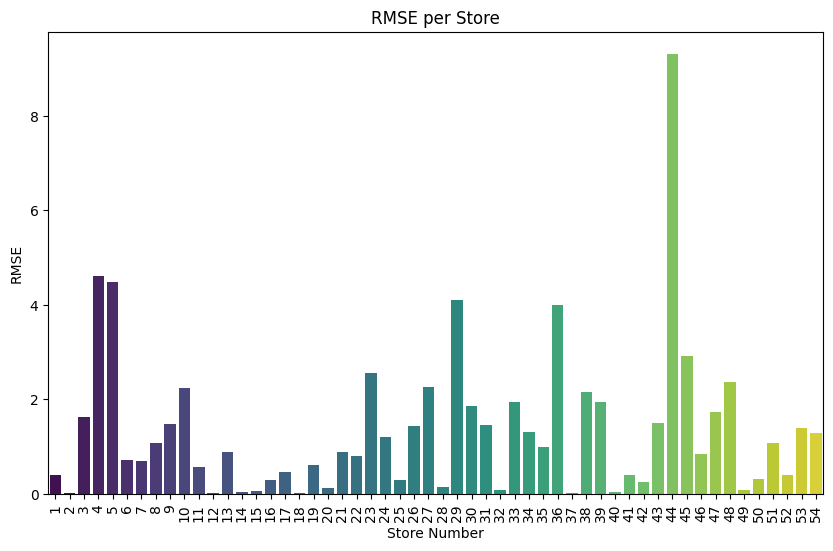

In [160]:
rmse_per_store = stores_data_indexed.groupby('store_nbr')['squared_error'].mean().apply(np.sqrt).reset_index()

rmse_per_store.rename(columns={'squared_error': 'rmse'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='store_nbr', y='rmse', data=rmse_per_store, palette='viridis')

plt.title('RMSE per Store')
plt.xlabel('Store Number')
plt.ylabel('RMSE')

plt.xticks(rotation=90)
plt.show()

C:\Users\CSamarajeewa\AppData\Local\Temp\ipykernel_21868\2973711263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='rmse', data=rmse_per_store_type, palette='viridis')


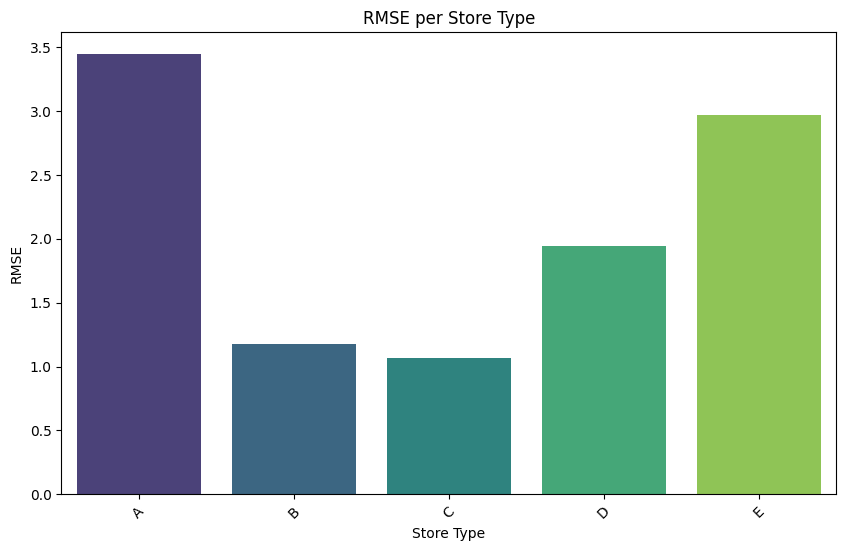

In [168]:
rmse_per_store_type = stores_data_indexed.groupby('type')['squared_error'].mean().apply(np.sqrt).reset_index()

rmse_per_store_type.rename(columns={'squared_error': 'rmse'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='rmse', data=rmse_per_store_type, palette='viridis')

plt.title('RMSE per Store Type')
plt.xlabel('Store Type')
plt.ylabel('RMSE')

plt.xticks(rotation=45)
plt.show()


C:\Users\CSamarajeewa\AppData\Local\Temp\ipykernel_21868\3086241890.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='family', y='rmse', data=rmse_per_class, palette='viridis')


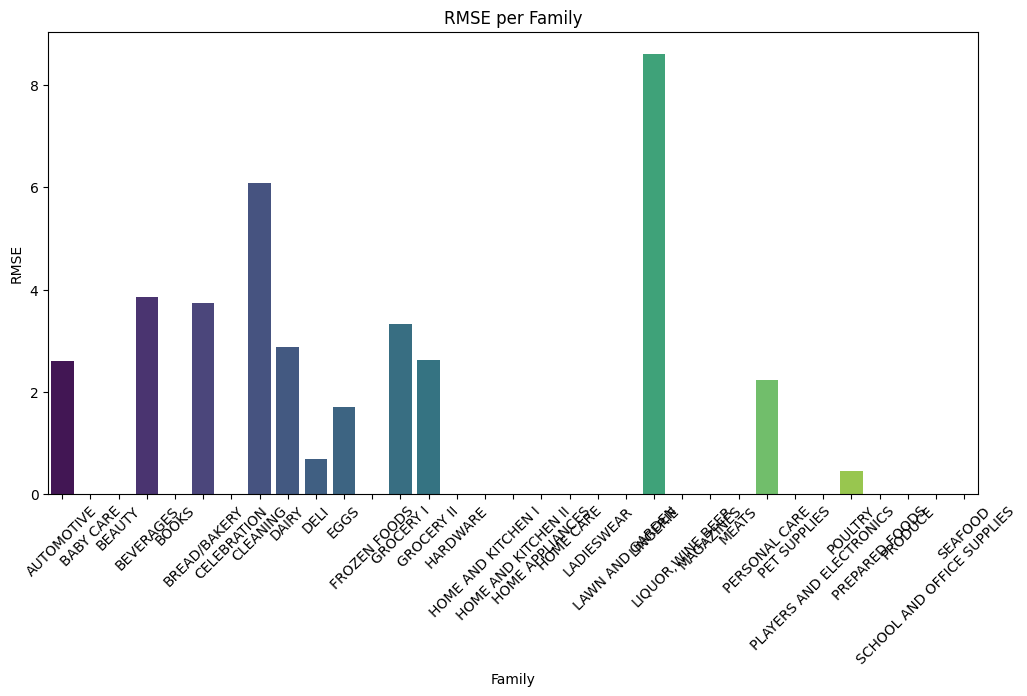

In [172]:
rmse_per_class = items_data_indexed.groupby('family')['squared_error'].mean().apply(np.sqrt).reset_index()

rmse_per_class.rename(columns={'squared_error': 'rmse'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='rmse', data=rmse_per_class, palette='viridis')

plt.title('RMSE per Family')
plt.xlabel('Family')
plt.ylabel('RMSE')

plt.xticks(rotation=45)
plt.show()

C:\Users\CSamarajeewa\AppData\Local\Temp\ipykernel_21868\466114513.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='perishable', y='rmse', data=rmse_per_perishable, palette='viridis')


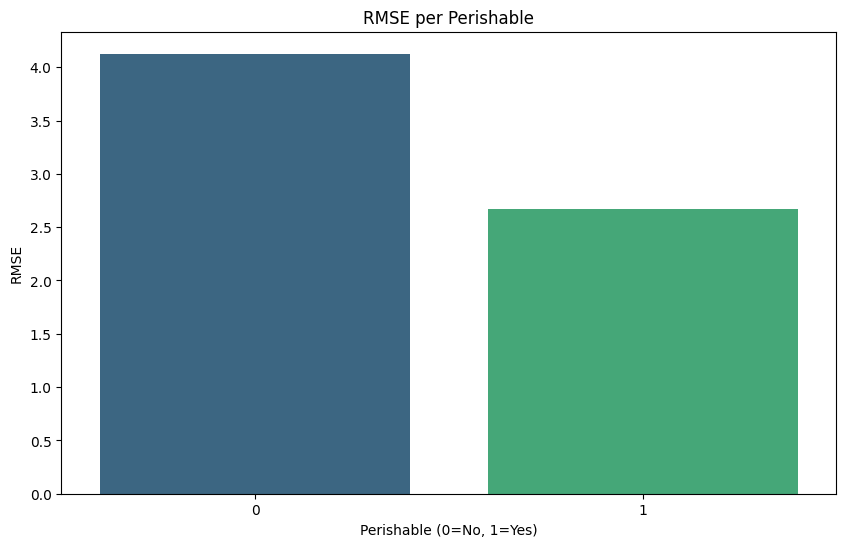

In [174]:
rmse_per_perishable = items_data_indexed.groupby('perishable')['squared_error'].mean().apply(np.sqrt).reset_index()

rmse_per_perishable.rename(columns={'squared_error': 'rmse'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='perishable', y='rmse', data=rmse_per_perishable, palette='viridis')

plt.title('RMSE per Perishable')
plt.xlabel('Perishable (0=No, 1=Yes)')
plt.ylabel('RMSE')

plt.show()